# Using the Scheduler

## Basic usage

In [1]:
import numpy as np

from qiskit import IBMQ, QuantumCircuit, transpile, schedule as build_schedule
from qiskit import circuit
from qiskit.pulse import Schedule, Gaussian, SamplePulse, DriveChannel, ControlChannel
from qiskit.test.mock import FakeAlmaden

/opt/miniconda3/lib/python3.7/site-packages/qiskit_aqua-0.7.0-py3.7.egg/qiskit/aqua/operators/primitive_ops/pauli_op.py:25: DeprecationWarning: The module qiskit.extensions.standard is deprecated as of 0.14.0 and will be removed no earlier than 3 months after the release. You should import the standard gates from qiskit.circuit.library.standard_gates instead.
  from qiskit.extensions.standard import RZGate, RYGate, RXGate, XGate, YGate, ZGate, IGate


In [2]:
circ = QuantumCircuit(1, 1)
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure([0, 1], [0, 1])

circ.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c_0: ═══════════╩══╬═
                   ║ 
c_1: ══════════════╩═

TODO

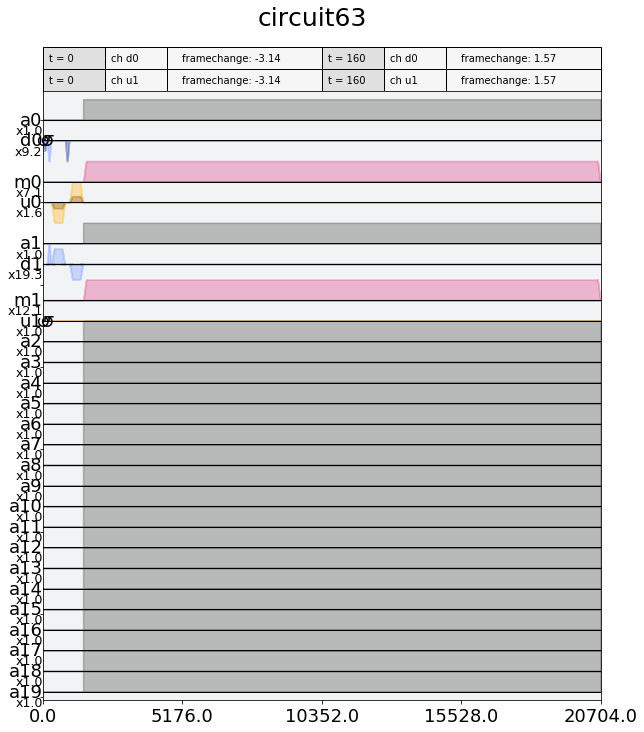

In [3]:
backend = FakeAlmaden()

transpiled_circ = transpile(circ, backend)
schedule = build_schedule(transpiled_circ, backend)
schedule.draw()

## Scheduling with custom gate definitions

In [4]:
custom_q0_h_schedule = Schedule(Gaussian(duration=128, amp=0.045, sigma=8)(DriveChannel(0)))

inst_map = backend.defaults().instruction_schedule_map
inst_map.add('h', 0, custom_q0_h_schedule)

schedule = build_schedule(circ, backend, inst_map=inst_map)

/opt/miniconda3/lib/python3.7/site-packages/qiskit_terra-0.14.0-py3.7-macosx-10.9-x86_64.egg/qiskit/pulse/pulse_lib/pulse.py:49: DeprecationWarning: Calling `Gaussian` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(Gaussian(duration=128, amp=(0.045+0j), sigma=8), DriveChannel(0))`.
  DeprecationWarning)


## Building circuits with non-standard gates

Design a new gate by giving it a name, specific qubits, and a pulse `Schedule` definition.

In [5]:
from qiskit.pulse.schedule import ParameterizedSchedule

random_pulse = lambda x: SamplePulse(np.random.random(max(x, 1)))

def my_perfect_2q_gate_schedule_func(x):
    sched = Schedule()
    sched += random_pulse(x)(DriveChannel(0))
    sched += random_pulse(x)(ControlChannel(0))
    sched += random_pulse(x)(DriveChannel(1))
    return sched

my_perfect_2q_gate_schedule = ParameterizedSchedule(my_perfect_2q_gate_schedule_func, parameters=('x'))

Add definition to instruction map

In [6]:
inst_map.add('my_perfect_2q_gate', (0, 1), my_perfect_2q_gate_schedule)

Build schedule as usual

In [7]:
my_perfect_2q_gate = circuit.Gate('my_perfect_2q_gate', 2, [100])

my_perfect_2q_circ = QuantumCircuit(2, 2)
my_perfect_2q_circ.h(0)
my_perfect_2q_circ.append(my_perfect_2q_gate, [0, 1])
my_perfect_2q_circ.h(0)
my_perfect_2q_circ.measure(0, 0)

my_perfect_2q_circ.draw()

┌───┐┌──────────────────────────┐┌───┐┌─┐
q_0: ┤ H ├┤0                         ├┤ H ├┤M├
     └───┘│  my_perfect_2q_gate(100) │└───┘└╥┘
q_1: ─────┤1                         ├──────╫─
          └──────────────────────────┘      ║ 
c_0: ═══════════════════════════════════════╩═
                                              
c_1: ═════════════════════════════════════════

Transpile with the new gate

In [8]:
my_perfect_2q_circ_transpiled = transpile(my_perfect_2q_circ,
                                          coupling_map=[[0, 1]],
                                          basis_gates=backend.configuration().basis_gates + ['my_perfect_2q_gate'])
my_perfect_2q_circ_transpiled.draw()

┌──────────┐┌──────────────────────────┐┌──────────┐┌─┐
q_0 -> 0 ┤ U2(0,pi) ├┤0                         ├┤ U2(0,pi) ├┤M├
         └──────────┘│  my_perfect_2q_gate(100) │└──────────┘└╥┘
q_1 -> 1 ────────────┤1                         ├─────────────╫─
                     └──────────────────────────┘             ║ 
    c_0: ═════════════════════════════════════════════════════╩═
                                                                
    c_1: ═══════════════════════════════════════════════════════

/opt/miniconda3/lib/python3.7/site-packages/qiskit_terra-0.14.0-py3.7-macosx-10.9-x86_64.egg/qiskit/pulse/pulse_lib/sample_pulse.py:153: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(samples), DriveChannel(0))`.
  DeprecationWarning)
/opt/miniconda3/lib/python3.7/site-packages/qiskit_terra-0.14.0-py3.7-macosx-10.9-x86_64.egg/qiskit/pulse/pulse_lib/pulse.py:49: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(array([0.30110631+0.j, 0.10810737+0.j, 0.03998606+0.j, 0.31636986+0.j,
       0.61695352+0.j, 0.46061295+0.j, 0.20461338+0.j, 0.31296634+0.j,
       0.3620973 +0.j, 0.35520896+0.j, 0.34029644+0.j, 0.98193977+0.j,
       0.8320206 +0.j, 0.29558013+0.j, 0.53739644+0.j, 0.49689595+0.j,
       0.255657

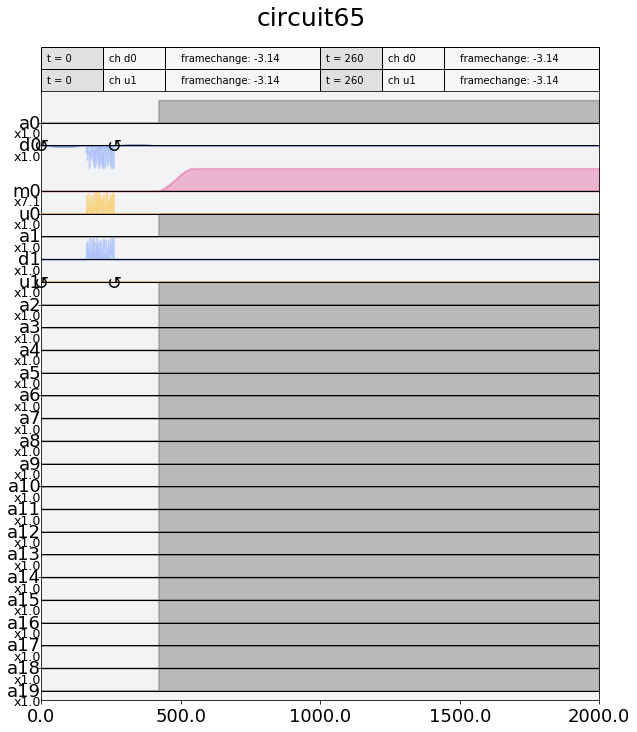

In [9]:
my_perfect_2q_pulse_program = build_schedule(my_perfect_2q_circ_transpiled,
                                             backend,
                                             inst_map=inst_map)
my_perfect_2q_pulse_program.draw(plot_range=(0, 2000))